In [1]:
from torch.nn import AdaptiveMaxPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, Softmax, Embedding

import torch
import torchvision
from torch import optim
import torch.utils.model_zoo as model_zoo
import time
from torchsummary import summary
import os
from easydict import EasyDict as edict
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as trans
from torchvision.datasets import ImageFolder
from torch.utils.data import  DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
#from tensorboardX import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_curve
import numpy as np
from torch.nn import init
from collections import namedtuple
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Parameter, Module, CrossEntropyLoss, DataParallel

#### Image Width, Image Height was set to 224 in this work.
#### RGB Images of Forehead ROI have been used.
#### Embedding Dimension is set to 512.
## Do Not Modify or delete the below code cell.

In [2]:
img_width = 224
img_height = 224
channels = 3
embedding_dim = 512

size1_new = int(np.floor(img_width/2))
size2_new = int(np.floor(img_height/2))

size1_new = int(np.ceil(size1_new/2))
size2_new = int(np.ceil(size2_new/2))

size1_new = int(np.ceil(size1_new/2))
size2_new = int(np.ceil(size2_new/2))

size1_new = int(np.ceil(size1_new/2))
size2_new = int(np.ceil(size2_new/2))

size1_new = int(np.floor(size1_new/2))
size2_new = int(np.floor(size2_new/2))



In [3]:
def get_train_dataset(imgs_folder):
    if channels != 3:
        train_transform = trans.Compose([
            trans.Grayscale(num_output_channels=channels), 
            trans.Resize((img_width, img_height)), 
            trans.RandomHorizontalFlip(),
            trans.ToTensor(),
            trans.Normalize((0.5,), (0.5,))
            
        ])
    else:
        train_transform = trans.Compose([
            trans.Resize((img_width, img_height)), 
            trans.RandomHorizontalFlip(),
            trans.ToTensor(),
            trans.Normalize((0.5,), (0.5,))
        ])
    ds = ImageFolder(imgs_folder, train_transform)
    class_num = ds[-1][1] + 1
    return ds, class_num

### Code for ArcFace and CosFace has been obtained from the following repository: https://github.com/ronghuaiyang/arcface-pytorch/blob/master/models/metrics.py

In [4]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin

            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output


class AddMarginProduct(nn.Module):
    r"""Implement of large margin cosine distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin
        cos(theta) - m
    """

    def __init__(self, in_features, out_features, s=30.0, m=0.40):
        super(AddMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device='cuda')
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + 'in_features=' + str(self.in_features) \
               + ', out_features=' + str(self.out_features) \
               + ', s=' + str(self.s) \
               + ', m=' + str(self.m) + ')'


class SphereProduct(nn.Module):
    r"""Implement of large margin cosine distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        m: margin
        cos(m*theta)
    """
    def __init__(self, in_features, out_features, m=4):
        super(SphereProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        self.base = 1000.0
        self.gamma = 0.12
        self.power = 1
        self.LambdaMin = 5.0
        self.iter = 0
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform(self.weight)

        # duplication formula
        self.mlambda = [
            lambda x: x ** 0,
            lambda x: x ** 1,
            lambda x: 2 * x ** 2 - 1,
            lambda x: 4 * x ** 3 - 3 * x,
            lambda x: 8 * x ** 4 - 8 * x ** 2 + 1,
            lambda x: 16 * x ** 5 - 20 * x ** 3 + 5 * x
        ]

    def forward(self, input, label):
        # lambda = max(lambda_min,base*(1+gamma*iteration)^(-power))
        self.iter += 1
        self.lamb = max(self.LambdaMin, self.base * (1 + self.gamma * self.iter) ** (-1 * self.power))

        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cos_theta = F.linear(F.normalize(input), F.normalize(self.weight))
        cos_theta = cos_theta.clamp(-1, 1)
        cos_m_theta = self.mlambda[self.m](cos_theta)
        theta = cos_theta.data.acos()
        k = (self.m * theta / 3.14159265).floor()
        phi_theta = ((-1.0) ** k) * cos_m_theta - 2 * k
        NormOfFeature = torch.norm(input, 2, 1)

        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cos_theta.size())
        one_hot = one_hot.cuda() if cos_theta.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1), 1)

        # --------------------------- Calculate output ---------------------------
        output = (one_hot * (phi_theta - cos_theta) / (1 + self.lamb)) + cos_theta
        output *= NormOfFeature.view(-1, 1)

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + 'in_features=' + str(self.in_features) \
               + ', out_features=' + str(self.out_features) \
               + ', m=' + str(self.m) + ')'

### Code for Attention Modules have been obtained from: https://github.com/xmu-xiaoma666/External-Attention-pytorch

In [5]:
class PAM_Module(nn.Module):
    """ Position attention module"""
    #Ref from SAGAN
    def __init__(self, in_dim = 512):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = Parameter(torch.zeros(1))

        self.softmax = Softmax(dim=-1)
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        #out = self.gamma*out
        out = self.gamma*out + x
        return out

class ECAAttention(nn.Module):

    def __init__(self, kernel_size=5):
        super().__init__()
        self.gap=nn.AdaptiveAvgPool2d(1)
        self.conv=nn.Conv1d(1,1,kernel_size=kernel_size,padding=(kernel_size-1)//2)
        self.sigmoid=nn.Sigmoid()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        y=self.gap(x) #bs,c,1,1
        y=y.squeeze(-1).permute(0,2,1) #bs,1,c
        y=self.conv(y) #bs,1,c
        y=self.sigmoid(y) #bs,1,c
        y=y.permute(0,2,1).unsqueeze(-1) #bs,c,1,1
        return x*y.expand_as(x)


In [6]:

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class IRBlock(nn.Module): 
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)

    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.prelu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.PReLU(),
                nn.Linear(channel // reduction, channel),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class ResNetFace(nn.Module):
    def __init__(self, block, layers, use_se=True):
        self.inplanes = 64
        self.use_se = use_se
        super(ResNetFace, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.sattention = PAM_Module()
        self.cattention = ECAAttention(kernel_size = 5)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()
        
        self.fc5 = nn.Linear(512 * (size1_new) * (size2_new), embedding_dim)
        self.bn5 = nn.BatchNorm1d(embedding_dim)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        
        x = self.maxpool(x)
        
        
        s_x = self.sattention(x) #spatial or positional attention.
        c_x = self.cattention(x)
        
        x = c_x + s_x #Element Sum Concat of Attention Outputs.
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.bn5(x)
        return x

def resnet_18(use_se=True, **kwargs):
    model = ResNetFace(IRBlock, [2, 2, 2, 2], use_se=use_se, **kwargs)
    return model

# Load The Dataset. Replace below lines accordingly.

In [7]:
ds, class_num = get_train_dataset("/home/rohit.bharadwaj/Projects/forehead/Data_Cropped/train")
ds2, class_num2 = get_train_dataset("/home/rohit.bharadwaj/Projects/forehead/Data_Cropped/test")

### Configuration Settings for the Network.

In [10]:
class Config(object):
    env = 'default'
    backbone = 'resnet18'
    classify = 'softmax'
    num_classes = class_num
    metric = 'add_margin' #add_margin for CosFace and arc_margin for ArcFace loss.
    easy_margin = False
    use_se = False
    #loss = "cross_entropy"
    loss = 'focal_loss'

    pin_memory = True
    
    display = True
    finetune = False

    checkpoints_path = '/home/rohit.bharadwaj/Projects/forehead/checkpoints' #folder name where the checkpoints will be stored.
    load_model_path = '/home/rohit.bharadwaj/Projects/forehead/models/resnet18.pth'
    test_model_path = '/home/rohit.bharadwaj/Projects/forehead/checkpoints/resnet18_110.pth'
    save_interval = 100

    train_batch_size = 16  # batch size
    test_batch_size = 32

    input_shape = (channels, img_width, img_height)

    optimizer = 'adam'

    use_gpu = True  # use GPU or not
    gpu_id = '0, 1'
    num_workers = 2  # how many workers for loading data
    print_freq = 100  # print info every N batch

    debug_file = '/tmp/debug'  # if os.path.exists(debug_file): enter ipdb
    result_file = 'result.csv'

    
    max_epoch = 100
    lr = 3e-4  # initial learning rate before 1e-3
    lr_step = 20
    lr_decay = 0.95  # when val_loss increase, lr = lr*lr_decay
    weight_decay = 5e-4


In [14]:
opt = Config()
loader = DataLoader(ds, batch_size= opt.train_batch_size, shuffle=True, pin_memory= opt.pin_memory, num_workers= opt.num_workers)
test_loader = DataLoader(ds2, batch_size = opt.test_batch_size)
class_names = ds.classes

device = torch.device("cuda") # Train on GPU.
if opt.loss == 'focal_loss':
    criterion = FocalLoss(gamma=2)
else:
    criterion = torch.nn.CrossEntropyLoss()

model = resnet_18(use_se=opt.use_se)


if opt.metric == 'add_margin':
    metric_fc = AddMarginProduct(embedding_dim, opt.num_classes, s=300, m=0.35)
elif opt.metric == 'arc_margin':
    metric_fc = ArcMarginProduct(embedding_dim, opt.num_classes, s=300, m=0.35, easy_margin=opt.easy_margin)
elif opt.metric == 'sphere':
    metric_fc = SphereProduct(embedding_dim, opt.num_classes, m=4)
else:
    metric_fc = nn.Linear(embedding_dim, opt.num_classes)

model.to(device)
model = DataParallel(model)
metric_fc.to(device)
metric_fc = DataParallel(metric_fc)
if opt.optimizer == 'sgd':
    optimizer = torch.optim.SGD([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                lr=opt.lr, weight_decay=opt.weight_decay)
else:
    optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                 lr=opt.lr, weight_decay=opt.weight_decay)
scheduler = StepLR(optimizer, step_size=opt.lr_step, gamma=0.1) #decays learning rate by gamma every step_size epochs

In [15]:
def save_model(model, save_path, name, iter_cnt):
    save_name = os.path.join(save_path, name + '_' + str(iter_cnt) + '.pth')
    torch.save(model.state_dict(), save_name)
    return save_name

# Do Training

Epoch: 1, Training Accuracy: 0.0%, Loss: 128.71
Epoch: 2, Training Accuracy: 0.0%, Loss: 112.18
Epoch: 3, Training Accuracy: 0.04%, Loss: 104.18
Epoch: 4, Training Accuracy: 0.93%, Loss: 89.95
Epoch: 5, Training Accuracy: 3.45%, Loss: 69.44
Epoch: 6, Training Accuracy: 11.41%, Loss: 48.88
Epoch: 7, Training Accuracy: 22.66%, Loss: 33.24
Epoch: 8, Training Accuracy: 32.94%, Loss: 24.46
Epoch: 9, Training Accuracy: 46.63%, Loss: 16.51
Epoch: 10, Training Accuracy: 54.59%, Loss: 11.78
Epoch: 11, Training Accuracy: 65.96%, Loss: 7.56
Epoch: 12, Training Accuracy: 67.14%, Loss: 6.78
Epoch: 13, Training Accuracy: 73.19%, Loss: 5.08
Epoch: 14, Training Accuracy: 75.67%, Loss: 4.1
Epoch: 15, Training Accuracy: 78.23%, Loss: 3.21
Epoch: 16, Training Accuracy: 79.45%, Loss: 2.95
Epoch: 17, Training Accuracy: 82.13%, Loss: 2.34
Epoch: 18, Training Accuracy: 85.05%, Loss: 1.64
Epoch: 19, Training Accuracy: 83.59%, Loss: 1.85
Epoch: 20, Training Accuracy: 86.56%, Loss: 1.42
Epoch: 21, Training Accu

'/home/rohit.bharadwaj/Projects/forehead/checkpoints/Model_Weights_final.pth'

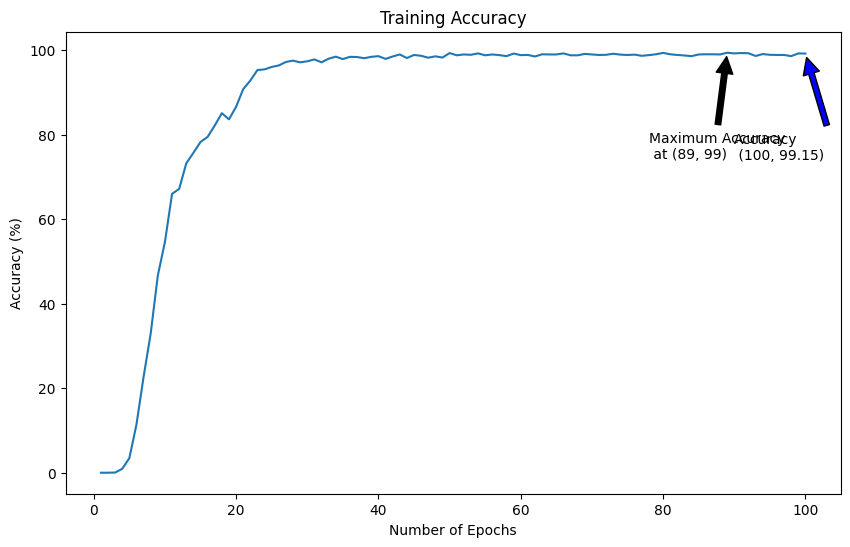

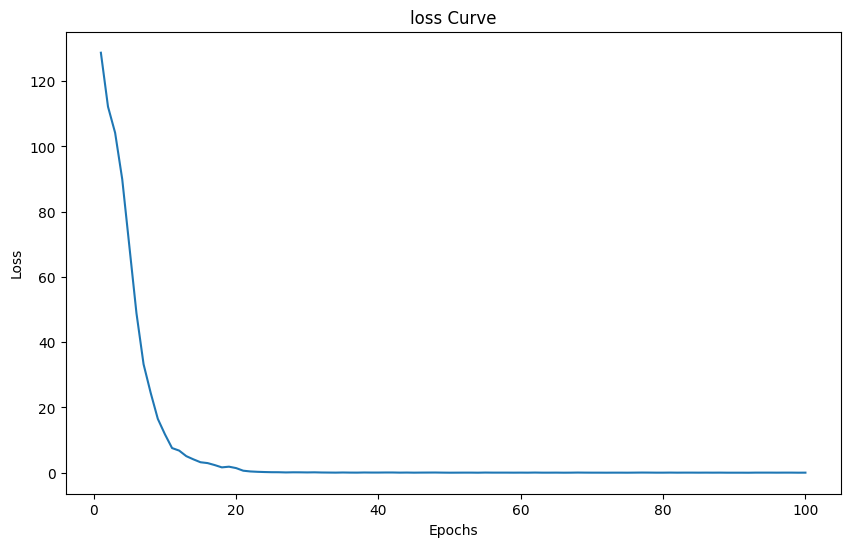

In [16]:
train_acc = []
loss_list = []
for i in range(opt.max_epoch):
    
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    model.train()
    for ii, data in enumerate(loader):
        data_input, label = data
        data_input = data_input.to(device)
        bs = data_input.shape[0]
        label = label.to(device).long()
        feature = model(data_input)
        output = metric_fc(feature, label)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += (bs * loss.item())
        
        with torch.no_grad():
            output = output.data.cpu().numpy()
            output = np.argmax(output, axis = 1)
            label = label.data.cpu().numpy()
            
            total_train += label.shape[0]
            correct_train += (output == label).sum().item()
            

    if i % opt.save_interval == 0 or i == opt.max_epoch:
        save_model(model, opt.checkpoints_path, "Model_Weights", i)
        
    
    train_acc.append(np.round(100 * correct_train / total_train,2))
    print(f"Epoch: {i+1}, Training Accuracy: {np.round(100 * correct_train / total_train,2)}%, Loss: {np.round(running_loss / total_train,2)}")
    loss_list.append(np.round(running_loss / total_train,2) )
    scheduler.step()

plt.figure(figsize=(10,6))
plt.title("Training Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy (%)")

plt.annotate(f'Maximum Accuracy\n at ({np.argmax(train_acc)+1}, {int(max(train_acc))}) ', xy=(np.argmax(train_acc)+1, max(train_acc)), xytext=(np.argmax(train_acc)-10, max(train_acc)-25),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.annotate(f'Accuracy\n ({len(train_acc)}, {train_acc[-1]}) ', xy=(len(train_acc), train_acc[-1]), xytext=(len(train_acc)-10, train_acc[-1]-25),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             )
plt.plot(range(1,opt.max_epoch+1), train_acc)
plt.savefig("train_accuracy.png")

plt.figure(figsize = (10,6))
plt.title("loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1, opt.max_epoch+1), loss_list)
plt.savefig("loss_curve.png")


import pickle
with open("loss_data.pkl", "wb") as file:
  pickle.dump(loss_list, file)


save_model(model, opt.checkpoints_path, "Model_Weights", "final")

# Load Embeddings in Memory

In [33]:
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)



def get_dataset_modified(imgs_folder):
    if channels != 3:
        train_transform = trans.Compose([
            trans.Grayscale(num_output_channels=channels),
            trans.Resize((img_width, img_height)),
            trans.RandomHorizontalFlip(),
            trans.ToTensor(),
            trans.Normalize((0.5,), (0.5,))
        ])
    else:
        train_transform = trans.Compose([
            trans.Resize((img_width, img_height)),
            trans.RandomHorizontalFlip(),
            trans.ToTensor(),
            trans.Normalize((0.5,), (0.5,))
        ])
    ds = ImageFolderWithPaths(imgs_folder, train_transform)
    class_num = ds[-2][1] + 1
    return ds, class_num


ds3, cnum = get_dataset_modified("/home/rohit.bharadwaj/Projects/forehead/Data_Cropped/test")
ds4, cnum2 = get_dataset_modified("/home/rohit.bharadwaj/Projects/forehead/Data_Cropped/train")

new_loader = DataLoader(ds3, batch_size = 1)
new_loader_train = DataLoader(ds4, batch_size = 1)


embedding_dict_test = {}
embedding_dict_train = {}
with torch.no_grad():
    model.eval()
    for i, data in enumerate(new_loader, 0):
            images, labels, path = data
            images = images.to(device)
            feature_test = model(images) #512 dimensional embedding
            idx1 = path[0].split("/")[-2] 
            pose1 = path[0].split("/")[-1][:-4]
            embedding_dict_test[str(idx1)+"_"+str(pose1)] = feature_test.cpu()

    for i2, data_train in enumerate(new_loader_train):
            images_train, labels_train, path_train = data_train
            images_train = images_train.to(device)
            feature_train = model(images_train)
            idx2 = path_train[0].split("/")[-2] 
            pose2 = path_train[0].split("/")[-1][:-4]
            embedding_dict_train[str(idx2)+"_"+str(pose2)] = feature_train.cpu()


In [39]:
embedding_dict_test.keys()

dict_keys(['1_11', '1_12', '1_13', '1_14', '1_15', '1_16', '1_17', '1_18', '1_19', '1_20', '1_21', '1_22', '1_23', '1_24', '1_25', '1_26', '1_27', '1_28', '1_29', '1_30', '10_11', '10_12', '10_13', '10_14', '10_15', '10_16', '10_17', '10_18', '10_19', '10_20', '100_11', '100_12', '100_13', '100_14', '100_15', '100_16', '100_17', '100_18', '100_19', '100_20', '101_11', '101_12', '101_13', '101_14', '101_15', '101_16', '101_17', '101_18', '101_19', '101_20', '102_11', '102_12', '102_13', '102_14', '102_15', '102_16', '102_17', '102_18', '102_19', '102_20', '103_11', '103_12', '103_13', '103_14', '103_15', '103_16', '103_17', '103_18', '103_19', '103_20', '104_11', '104_12', '104_13', '104_14', '104_15', '104_16', '104_17', '104_18', '104_19', '104_20', '105_11', '105_12', '105_13', '105_14', '105_15', '105_16', '105_17', '105_18', '105_19', '105_20', '106_11', '106_12', '106_13', '106_14', '106_15', '106_16', '106_17', '106_18', '106_19', '106_20', '107_11', '107_12', '107_13', '107_14',

In [36]:
len(embedding_dict_test.keys())

2502

In [37]:
len(embedding_dict_train.keys())

2462

#Create Matching Score File

In [ ]:
for k_test,v_test in embedding_dict_test.items():
  myKList = k_test.split("_")
  idx1 = myKList[0]
  pose1 = myKList[1]
  for k_train,v_train in embedding_dict_train.items():
    myKList2 = k_train.split("_")
    idx2 = myKList2[0]
    pose2 = myKList2[1]
    if idx1 == idx2:
      isGen = 1
    else:
      isGen = 0
    with open("scores.txt", "a") as file:
      file.write(str(idx1) + "\t" + str(pose1) + "\t" + str(idx2) + "\t" + str(pose2) + "\t" + str(isGen) + "\t" + str(torch.dist(v_test, v_train, p = 2).item()) + "\n")

# Once the Score file is created, you can compute standard biometric results like CRR, EER, DI, etc.

# Android and Network Code written by Rohit K Bharadwaj.
## Follow me on:
### Twitter: https://twitter.com/rohit901
### Github: https://github.com/rohit901
### LinkedIn: https://www.linkedin.com/in/rohit901/

